# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pipes
import random
import re
import tempfile
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
DISTANCE = "distance"
FACEMASK = "mondkapje"
TOPIC = DISTANCE
TOPIC = FACEMASK
if TOPIC == FACEMASK: FILETWEETS = TOPIC+"-tweets+nunl.csv"
else: FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
SOURCE = "source"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")
mainAnnotator = annotations.iloc[0][0]

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    if annotator == mainAnnotator and tweetId in list(tweets.index):
        tweetUser = tweets.loc[tweetId][1]
        tweetLabel = annotations.iloc[i][4]
        if tweetLabel == NEUTRAL: tweetLabel = IRRELEVANT
        if tweetLabel == ANDERS: tweetLabel = IRRELEVANT
        if tweetLabel == EENS: tweetLabel = SUPPORTS
        if tweetLabel == ONEENS: tweetLabel = REJECTS
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:preprocess(tweets.loc[tweetId][TEXT])}

In [6]:
len(fasttextData),len(tweets),len(annotations)

(2681, 8587, 2697)

In [7]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [8]:
annotations1 = annotations[annotations[0]==mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations1[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations1[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 6.7 ; 1000 tweets take: 149 minutes


In [9]:
annotations2 = annotations[annotations[0]!=mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations2[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations2[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 1.0 ; 1000 tweets take: 1000 minutes


## Fasttext run and evaluation

In [10]:
import fasttext
import random
from IPython.display import clear_output

In [11]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [12]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [13]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

1322

In [14]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [15]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [16]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        validationStart = round(fold*len(fasttextData)/n)
        validationEnd = round((fold+1)*len(fasttextData)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        testStart = round(nextFold*len(fasttextData)/n)
        testEnd = round((nextFold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i >= testStart and i < testEnd: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart and i < validationEnd: 
                print(data,file=validationFile)
                validationData.append(data)
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [17]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [18]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    fraction = sum(cf.loc['__label__SUPPORTS'])*sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])/\
             (sum(cf.loc['__label__REJECTS'])*sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))]))
    if printResults: print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

## Grid search

In [19]:
scoresValidation = {}
scoresTest = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200]:
        for lr in [0.05,0.1,0.2]:
            predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
                runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            key = ",".join([str(dim),str(epoch),str(lr)])
            print(f"{dim:3} {epoch:3} {lr:0.2f}",end=" validation: ")
            scoresValidation[key] = evaluate(predictionCountsValidation,predictionLabelsValidation,fasttextData)
            print(f"{dim:3} {epoch:3} {lr:0.2f}",end="       test: ")
            scoresTest[key] = evaluate(predictionCountsTest,predictionLabelsTest,fasttextData)

 10  10 0.05 validation: cases: 1322; precision: 0.391; recall: 0.391; fraction: inf
 10  10 0.05       test: cases: 1322; precision: 0.385; recall: 0.385; fraction: inf


/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


 10  10 0.10 validation: cases: 1322; precision: 0.462; recall: 0.462; fraction: 147.445
 10  10 0.10       test: cases: 1322; precision: 0.457; recall: 0.457; fraction: 153.711
 10  10 0.20 validation: cases: 1322; precision: 0.530; recall: 0.530; fraction: 4.349
 10  10 0.20       test: cases: 1322; precision: 0.525; recall: 0.525; fraction: 4.296
 10  20 0.05 validation: cases: 1322; precision: 0.464; recall: 0.464; fraction: 60.623
 10  20 0.05       test: cases: 1322; precision: 0.460; recall: 0.460; fraction: 80.184
 10  20 0.10 validation: cases: 1322; precision: 0.532; recall: 0.532; fraction: 3.490
 10  20 0.10       test: cases: 1322; precision: 0.532; recall: 0.532; fraction: 3.863
 10  20 0.20 validation: cases: 1322; precision: 0.545; recall: 0.545; fraction: 2.064
 10  20 0.20       test: cases: 1322; precision: 0.554; recall: 0.554; fraction: 2.003
 10  50 0.05 validation: cases: 1322; precision: 0.545; recall: 0.545; fraction: 2.309
 10  50 0.05       test: cases: 1322;

In [20]:
print("optimizing accuracy via validation data")
[(scoresValidation[k],k) for k in sorted(scoresValidation.keys(),\
                                         key=lambda k:scoresValidation[k][0],reverse=True)][0:10]

optimizing accuracy via validation data


[((0.559, 1.9350691096110575), '20,50,0.1'),
 ((0.558, 1.8928354584092288), '10,50,0.1'),
 ((0.558, 1.9407002631046346), '50,50,0.1'),
 ((0.557, 2.049891848816029), '200,20,0.2'),
 ((0.556, 1.876984126984127), '10,100,0.05'),
 ((0.556, 1.981661804785187), '200,50,0.1'),
 ((0.555, 1.907024629761622), '20,100,0.05'),
 ((0.555, 1.8928354584092288), '50,100,0.05'),
 ((0.554, 2.0358319776415135), '300,20,0.2'),
 ((0.553, 1.9996412209526964), '300,50,0.1')]

In [21]:
print("checking best accuracy for test data")
[(scoresTest[k],k) for k in sorted(scoresTest.keys(),\
                                         key=lambda k:scoresTest[k][0],reverse=True)][0:10]

checking best accuracy for test data


[((0.56, 2.054504693848956), '20,20,0.2'),
 ((0.559, 1.8330044525399716), '20,100,0.05'),
 ((0.559, 1.893767889669529), '50,50,0.1'),
 ((0.558, 1.7929321090913597), '10,50,0.1'),
 ((0.558, 1.877559456910695), '20,50,0.1'),
 ((0.558, 1.8720045472748648), '300,50,0.1'),
 ((0.557, 1.788755969083838), '10,100,0.05'),
 ((0.557, 1.8302848613640963), '50,100,0.05'),
 ((0.556, 1.9049570647931304), '200,100,0.05'),
 ((0.556, 1.8914467310002714), '300,100,0.05')]

Facemasks: best validation accuracy 0.56 for '20,50,0.1', associated test accuracy 0.56 (5th score).

Social distancing: best validation accuracy 0.65 for '300,10,0.2', associated test accuracy 0.65 (top score).

In [22]:
print("optimizing fraction via validation data")
[(scoresValidation[k],k) for k in sorted(scoresValidation.keys(),
                                         key=lambda k:scoresValidation[k][1])][0:10]

optimizing fraction via validation data


[((0.543, 1.480744980114463), '10,200,0.2'),
 ((0.542, 1.484408232714898), '20,200,0.2'),
 ((0.544, 1.4909912875545899), '10,200,0.1'),
 ((0.535, 1.4942210946309307), '50,200,0.2'),
 ((0.539, 1.496133416227654), '100,200,0.2'),
 ((0.545, 1.498478452930205), '200,200,0.2'),
 ((0.541, 1.5235017104269404), '50,100,0.2'),
 ((0.543, 1.5304457630717312), '20,100,0.2'),
 ((0.54, 1.5328483466872282), '20,200,0.1'),
 ((0.538, 1.535441379003954), '200,100,0.2')]

In [23]:
print("checking fraction for test data")
[(scoresTest[k],k) for k in sorted(scoresTest.keys(),
                                         key=lambda k:scoresTest[k][1])][0:10]

checking fraction for test data


[((0.542, 1.6587773949160605), '20,200,0.2'),
 ((0.542, 1.666260601208915), '300,200,0.2'),
 ((0.548, 1.6694105833450095), '100,200,0.2'),
 ((0.543, 1.6877607379987074), '200,200,0.2'),
 ((0.543, 1.6894937181822427), '50,200,0.1'),
 ((0.54, 1.6902873259298432), '300,100,0.2'),
 ((0.538, 1.692813913860979), '200,100,0.2'),
 ((0.543, 1.6978670897232504), '10,200,0.2'),
 ((0.544, 1.702920265585522), '300,200,0.1'),
 ((0.542, 1.7098229698679714), '20,200,0.1')]

Facemasks: best validation ratio: 1.48 for '10,200,0.2'; associated test ratio: 1.70 (8th scsore)

Social distancing: best validation ratio 0.88 for '200,200,0.2'; associated test accuracy 0.83 (top score).

In [ ]:
N = 5
scoresN = {} 
triplets = [(20,300,0.2),(50,200,0.2),(300,200,0.2),(20,200,0.05),(10,300,0.2)]

for triplet in triplets:
    dim,epoch,lr = triplet
    key = " ".join([str(dim),str(epoch),str(lr)])
    scoresN[key] = []
    for i in range(0,N): 
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
        print(dim,epoch,lr,end=" ")
        scoresN[key].append(evaluate(predictionCounts,predictionLabels,fasttextData))

In [ ]:
scoresNaverage = {}
for key in scoresN: scoresNaverage[key] = round(np.average([x[1] for x in scoresN[key]]),3)
{key:scoresNaverage[key] for key in sorted(scoresNaverage.keys(),key=lambda k:scoresNaverage[k],reverse=True)}

In [ ]:
for dim in [10]:
    for epoch in [900]:
        for lr in [0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = ",".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

## Run with best parameters

In [24]:
def setBestParameters():
    if TOPIC == DISTANCE:
        # social distancing (202008: 20,300,0.9) (202009:20,10,0.05) (202009:10,10,0.2)
        BESTDIM = 200
        BESTEPOCH = 200
        BESTLR = 0.2
    elif TOPIC == FACEMASK:
        # facemasks (202008: 10,900,0.2)
        BESTDIM = 10
        BESTEPOCH = 200
        BESTLR = 0.2
    else:
        print("unknown topic!",file=sys.stderr)
        sys.exit(1)
    return(BESTDIM,BESTEPOCH,BESTLR)
        
BESTDIM,BESTEPOCH,BESTLR = setBestParameters()

In [25]:
predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
    runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [26]:
evaluate(predictionCountsValidation,predictionLabelsValidation,fasttextData)
evaluate(predictionCountsTest,predictionLabelsTest,fasttextData)

cases: 1322; precision: 0.537; recall: 0.537; fraction: 1.467
cases: 1322; precision: 0.539; recall: 0.539; fraction: 1.714


(0.539, 1.7139781893880255)

In [27]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__IRRELEVANT': 558, '__label__REJECTS': 549, '__label__SUPPORTS': 215}

In [28]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.422


In [29]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabelsTest)):
    for label in predictionLabelsTest[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__IRRELEVANT': 494, '__label__REJECTS': 674, '__label__SUPPORTS': 154}

In [30]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 250


In [31]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__IRRELEVANT': 0.115, '__label__REJECTS': 0.228, '__label__SUPPORTS': 0.284}


In [32]:
makeConfusionMatrix(fasttextData,predictionLabelsTest)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,195,296,67
__label__REJECTS,212,274,63
__label__SUPPORTS,87,104,24


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [33]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__IRRELEVANT': 1.1295546558704452,
 '__label__REJECTS': 0.814540059347181,
 '__label__SUPPORTS': 1.396103896103896}

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [34]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

1322.0 1322


## Relation data size - accuracy (skip)

In [ ]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000,10000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest = \
            runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCountsTest,predictionLabelsTest,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

In [ ]:
del(expResultsAll[list(expResultsAll.keys())[-1]])

In [ ]:
PLOTFILENAME = "training-size.png"

plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("training data size")
plt.title("Accuracy related to training size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("fraction")
plt.xlabel("training data size")
plt.title("Fraction score related to training size")
plt.savefig(PLOTFILENAME)
plt.show()

## Classifying unlabeled tweets

In [35]:
import fasttext
import matplotlib
import numpy as np
import os
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer

In [36]:
BESTDIM,BESTEPOCH,BESTLR = setBestParameters()

In [37]:
BASEDIR = "/home/erikt/projects/puregome/data/"
DATADIRECTORY = BASEDIR+"text/"
DATADIRECTORYREDDIT = BASEDIR+"reddit/text/"
DATADIRECTORYNUNL = BASEDIR+"nunl/text/"
TWITTER = "twitter"
REDDIT = "reddit"
NUNL = "nunl"
SOURCES = [TWITTER,REDDIT,NUNL]
DATADIRECTORIES = {TWITTER:DATADIRECTORY,REDDIT:DATADIRECTORYREDDIT,NUNL:DATADIRECTORYNUNL}
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
TEXT = "text"
USER = "user"
TOTAL = "total"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [38]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [39]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query,dataDirectory=DATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                matchedText = [line for line in fileData[TEXT] if re.search(query,line,flags=re.IGNORECASE)]
                matchedTextPreprocessed = [preprocess(line) for line in matchedText]
                testData.extend(matchedTextPreprocessed)
            except:
                pass
    return(testData)
    
def classify(datePattern,query,model,dataDirectory=DATADIRECTORY):
    testData = readData(datePattern,query,dataDirectory)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    labelPercentages[TOTAL] = nbrOfLabels
    return(labelPercentages)

In [40]:
import ast

RESULTSFILE = "results-"+TOPIC+".csv"

def storeResults(results):
     pd.DataFrame(results).T.to_csv(RESULTSFILE,index_label=SOURCE)
        
def readResults():
    df = pd.read_csv(RESULTSFILE,index_col=SOURCE)
    for source in df.index:
        for date in df.loc[source].index:
            try:
                df.loc[source][date] = ast.literal_eval(df.loc[source][date])
            except: pass
    return(removeNan(df.T.to_dict()))

def getTotals(results):
    totals = {}
    for source in results:
        for date in results[source]:
            try:
                if not source in totals: totals[source] = 0
                totals[source] += results[source][date][TOTAL]
            except: pass
    return(totals)

def removeNan(results):
    for source in results:
        toBeDeleted = []
        for date in results[source]:
            if results[source][date] != results[source][date]:
                toBeDeleted.append(date)
        for date in toBeDeleted: del(results[source][date])
    return(results)

results = readResults()
totals =  getTotals(results)

In [41]:
MAXDAYSPERMONTH = 31

if TOPIC == DISTANCE:
    QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
elif TOPIC == FACEMASK:
    QUERY = TOPIC
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)
MAXDAYSPERMONTH = 31

model = fasttext.train_supervised(FILEFASTTEXT,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

### Recompute results per data source (time-consuming: usually skipped)

In [42]:
results = {}
totals = {}
for source in SOURCES:
    dataDirectory = DATADIRECTORIES[source]
    total = 0
    results[source] = {}
    for month in "202002 202003 202004 202005 202006 202007 202008".split():
        for day in range(1,MAXDAYSPERMONTH+1):
            date = month+str(day).zfill(2)
            try:
                labels = classify(date,QUERY,model,dataDirectory=dataDirectory)
                if not REJECTS in labels: labels[REJECTS] = 0
                if not SUPPORTS in labels: labels[SUPPORTS] = 0
                if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
                if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                    results[source][date] = labels
                    print(source,date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT],labels[TOTAL])
                    total += labels[TOTAL]
            except:
                print(source,date,"error")
    totals[source] = total
    print("total relevant found:",total)

twitter 20200201 91.3 8.7 131.7 126
twitter 20200202 90.8 9.2 119.2 120
twitter 20200203 80.2 19.8 97.7 86
twitter 20200204 92.6 7.4 59.0 122
twitter 20200205 64.5 35.5 73.7 76
twitter 20200206 83.3 16.7 63.6 66
twitter 20200207 74.0 26.0 65.0 100
twitter 20200208 84.2 15.8 60.0 95
twitter 20200209 71.9 28.1 90.6 32
twitter 20200210 79.6 20.4 83.3 54
twitter 20200211 96.9 3.1 78.1 32
twitter 20200212 60.5 39.5 73.7 38
twitter 20200213 90.3 9.7 90.3 31
twitter 20200214 78.9 21.1 105.3 19
twitter 20200215 83.3 16.7 33.3 30
twitter 20200216 93.1 6.9 41.4 29
twitter 20200217 81.0 19.0 79.4 63
twitter 20200218 87.0 13.0 164.8 54
twitter 20200219 95.8 4.2 83.3 24
twitter 20200220 87.5 12.5 50.0 16
twitter 20200221 92.8 7.2 158.8 97
twitter 20200222 77.1 22.9 162.5 144
twitter 20200223 82.9 17.1 115.9 82
twitter 20200224 87.1 12.9 95.5 201
twitter 20200225 85.5 14.5 60.3 785
twitter 20200226 78.7 21.3 47.9 980
twitter 20200227 79.9 20.1 67.6 1129
twitter 20200228 82.1 17.9 79.5 991
twitter 20

In [43]:
#storeResults(results)

In [44]:
totals

{'twitter': 431168, 'reddit': 1334, 'nunl': 18682}

In [45]:
for platform in "twitter reddit nunl".split():
    counts = {}
    for date in results[platform]:
        try:
            if TOTAL in results[platform][date] and results[platform][date][TOTAL] > 0:
                for label in results[platform][date].keys():
                    if not label in counts: counts[label] = 0
                    if label == TOTAL: counts[label] += results[platform][date][label]
                    else: counts[label] += round(results[platform][date][TOTAL]*results[platform][date][label]/100.0)
        except: pass
    print(platform,counts)

twitter {'__label__IRRELEVANT': 340888, '__label__REJECTS': 368207, '__label__SUPPORTS': 62961, 'total': 431168}
reddit {'__label__IRRELEVANT': 905, '__label__REJECTS': 1012, '__label__SUPPORTS': 322, 'total': 1334}
nunl {'__label__IRRELEVANT': 11166, '__label__REJECTS': 13559, '__label__SUPPORTS': 5123, 'total': 18682}


Social distancing:
twitter {"__label__IRRELEVANT": 73379, "__label__REJECTS": 156775, "__label__SUPPORTS": 589930, "total": 746705}
reddit {'__label__SUPPORTS': 2054, 'total': 2240, '__label__REJECTS': 186, '__label__IRRELEVANT': 43}
nunl {'__label__SUPPORTS': 24547, 'total': 29500, '__label__REJECTS': 4953, '__label__IRRELEVANT': 585}
Face masks:
twitter {'__label__IRRELEVANT': 279286, '__label__REJECTS': 313765, '__label__SUPPORTS': 51141, 'total': 364906}
reddit {'__label__IRRELEVANT': 703, '__label__REJECTS': 824, '__label__SUPPORTS': 262, 'total': 1086}
nunl {'__label__IRRELEVANT': 8939, '__label__REJECTS': 11289, '__label__SUPPORTS': 4181, 'total': 15470}

## Visualization over time

In [46]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [47]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

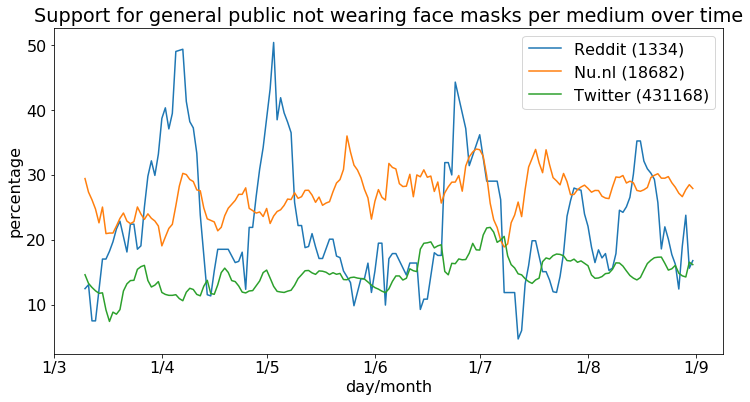

In [48]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7
STARTDATE = "20200310"
LABELS = {TWITTER:"Twitter ({0})".format(totals[TWITTER]),\
          NUNL:"Nu.nl ({0})".format(totals[NUNL]),\
          REDDIT:"Reddit ({0})".format(totals[REDDIT])}
if TOPIC == DISTANCE:
    PLOTFILENAME = "social-distancing-all.png"
elif TOPIC == FACEMASK:
    PLOTFILENAME = "mondkapje-all.png"
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)

x = {}
ySupports = {}
plt.subplots(figsize=(12,6))
font = {"size":16}
matplotlib.rc("font",**font)
ax = plt.subplot(111)
for source in [REDDIT,NUNL,TWITTER]:
    x[source] = [datetime.datetime.strptime(k,DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][SUPPORTS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label=LABELS[source])
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
if TOPIC == FACEMASK:
    plt.title("Support for general public not wearing face masks per medium over time")
elif TOPIC == DISTANCE:
    plt.title("Support for social distancing per medium over time (average over "+str(DAYSCOMBINED)+" days)")
else:
    print("unknown topic!",file=sys.stderr)
    sys.exit(1)    
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701 20200801 20200901".split()])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

## Do not run any further code

In [ ]:
ANNOTATED = "annotated"
ANNOTATEDFILE = "manual-annotation.csv"
DATE = "date"
EENS = "EENS"
ONEENS = "ONEENS"
ANDERS = "ANDERS"
TOTAL = "total"

In [ ]:
df = pd.read_csv(ANNOTATEDFILE,index_col=DATE,dtype={EENS:"float",ONEENS:"float",ANDERS:"float"})
totals = []
for i in range(0,len(df)):
    total = df.iloc[i][EENS]+df.iloc[i][ONEENS]+df.iloc[i][ANDERS]
    if df.iloc[i][EENS]+df.iloc[i][ONEENS] > 0:
        df.iloc[i][EENS] = 100*df.iloc[i][EENS]/(total-df.iloc[i][ANDERS])
        df.iloc[i][ONEENS] = 100*df.iloc[i][ONEENS]/(total-df.iloc[i][ANDERS])
        df.iloc[i][ANDERS] = 100*df.iloc[i][ANDERS]/(total-df.iloc[i][ANDERS])
    else: 
        df.iloc[i][ANDERS] = 100
    totals.append(total)
df[TOTAL] = totals
annotatedDict = df.T.to_dict(orient="dict")
annotatedDict = {d:annotatedDict[d] for d in sorted(annotatedDict.keys())}
results[ANNOTATED] = annotatedDict

In [ ]:
PLOTFILEANNOTATED = "manual-annotation.png"

x = {}
ySupports = {}
plt.subplots(figsize=(12,6))
font = {"size":12}
matplotlib.rc("font",**font)
ax = plt.subplot(111)
for source in [TWITTER]:
    x[source] = [datetime.datetime.strptime(k,DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][SUPPORTS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label="predicted")
for source in [ANNOTATED]:
    x[source] = [datetime.datetime.strptime(str(k),DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][EENS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label=ANNOTATED)
plt.title("Support for social distancing per medium over time (average over "+str(DAYSCOMBINED)+" days)")
plt.legend()
plt.savefig(PLOTFILEANNOTATED)
plt.show()

In [ ]:
annotatedValues = []
twitterValues = []

for i in range(0,len(x[TWITTER])):
    date = x[TWITTER][i]
    if date >= datetime.datetime.strptime("20200310",DATEFORMAT):
        for j in range(0,len(x[ANNOTATED])):
            if x[ANNOTATED][j] == date:
                twitterValues.append(ySupports[TWITTER][i])
                annotatedValues.append(ySupports[ANNOTATED][j])
np.corrcoef(annotatedValues,twitterValues)[1][0]

In [ ]:
PLOTFILENAME = "plot.png"

plt.figure()
plt.scatter(annotatedValues,twitterValues)
plt.ylabel("Predicted support percentages")
plt.xlabel("Annotated support percentages")
plt.title("Annotated and predicted support for social distancing")
plt.savefig(PLOTFILENAME)
plt.show()

In [ ]:
allResults = results
results = results[TWITTER]

x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

keyDates = []
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        keyDates.append(list(results.keys())[i])
        print(keyDates[-1])

In [ ]:
STARTDATE = "20200310" # keyDates[0]
ENDDATE = "20201231"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(14,7))

ax1 = plt.subplot(111)
plt.plot_date(x,ySupports,fmt="-",label="Supports")
plt.plot_date(x,yRejects,fmt="-",label="Rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="Other")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("stance on the RIVM policy on "+"social")
plt.show()

In [ ]:
PLOTFILEOUT = "social-distancing.png"
#PLOTFILEOUT = "mondkapje.png"

plt.subplots(figsize=(14,7))

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(111)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="Supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="Rejects")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("Twitter stance on the RIVM policy on social distancing (average over "+str(DAYSCOMBINED)+" days)")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701 20200801".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.savefig(PLOTFILEOUT)
plt.show()

In [ ]:
counts = {}
for text in fasttextData:
    label = text.split()[0]
    if label in counts: counts[label] += 1
    else: counts[label] = 1
for label in counts: print(round(counts[label]/len(fasttextData),3),label)

## Annotator comparison

In [ ]:
NBROFTESTDATA = 100

annotators = []
annotatorData = {}
kappaData = [{},{}]
blockedTweetIds = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if not annotator in annotatorData: 
        annotatorData[annotator] = {}
        annotators.append(annotator)
    annotatorData[annotator][tweetId] = tweetLabel
    if len(annotatorData[annotator]) <= NBROFTESTDATA: blockedTweetIds[tweetId] = True
    if len(annotators) >= 2 and not tweetId in blockedTweetIds and \
       tweetId in annotatorData[annotators[0]] and tweetId in annotatorData[annotators[1]]:
        kappaData[0][tweetId] = annotatorData[annotators[0]][tweetId]
        kappaData[1][tweetId] = annotatorData[annotators[1]][tweetId]

In [ ]:
for annotator in annotatorData:
    labelCount = {}
    for tweetId in annotatorData[annotator]:
        label = annotatorData[annotator][tweetId]
        if not label in labelCount: labelCount[label] = 0
        labelCount[label] += 1
    print(len(annotatorData[annotator]))
    for label in labelCount: print(round(labelCount[label]/len(annotatorData[annotator]),3),label)

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score([kappaData[0][tweetId] for tweetId in kappaData[0]],[kappaData[1][tweetId] for tweetId in kappaData[0]])

In [ ]:
MAX = 100

total = 0
identical = 0
for tweetId in annotatorData[mainAnnotator]:
    for annotator in annotators:
        if not annotator == mainAnnotator and tweetId in annotatorData[annotator]:
            total += 1
            if total <= MAX:
                if annotatorData[annotator][tweetId] == annotatorData[mainAnnotator][tweetId]: identical += 1
                else: 
                    print(tweetId,annotatorData[mainAnnotator][tweetId],annotatorData[annotator][tweetId])
                    #print(tweets.loc[tweetId][TEXT])
print(total,identical)